In [100]:
import GWPhotonCounting
import jax.numpy as jnp
import jax.scipy as jsp

from matplotlib.markers import MarkerStyle
import matplotlib as mpl

import matplotlib.pyplot as plt

frequencies = jnp.sort(jnp.fft.fftfreq(2**13, d=1/1e4))
detector = GWPhotonCounting.detector.Detector(frequencies, 'data/CE1_shot_psd.csv', 'data/CE1_classical_quanta.csv', 
                                              gamma=100, random_seed=1632, N_frequency_spaces=10)

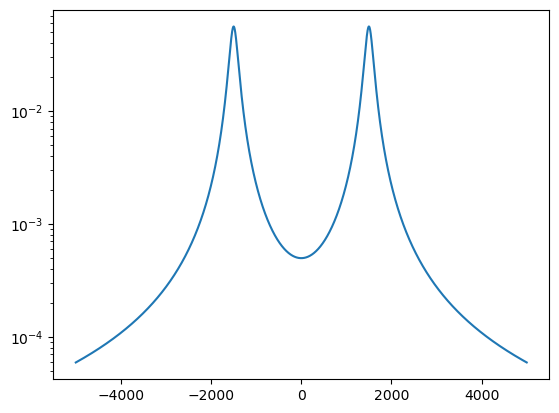

In [101]:
plt.semilogy(frequencies, jnp.abs(detector.filter_functions[0]))
plt.show()

In [102]:
LorentzianModel = GWPhotonCounting.signal.PostMergerLorentzian()

KNNModel = GWPhotonCounting.signal.PostMergerKNN()

/home/ethan.payne/.conda/envs/ve310/lib/python3.10/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator KNeighborsRegressor from version 1.5.1 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [167]:
PM_strain = KNNModel.generate_strain(detector, frequencies, 2.4, 0, 5e-3, 0, 0.5,0.0, 0.0)

#PM_strain = LorentzianModel.generate_strain(detector, frequencies, 2.75e3, 100, 1e-21, 0, 0)

#PM_strain = 1e-24 * detector.filter_functions[0]

In [168]:
n_sig_exp = detector.calculate_signal_photon_expectation(PM_strain, frequencies)

print(n_sig_exp)

[1.91542831e-08 5.46702027e-09 6.54723982e-10 1.28541259e-07
 3.49685390e-06 1.00728131e-05 5.31661295e-13 4.20283185e-06
 2.16568765e-04 4.62667577e-07 7.20231976e-04 9.65357248e-02
 6.13445049e-02 1.50383436e-07 4.08672226e-08 2.73194061e-04
 1.17875789e-05 1.41439074e-06 1.61092905e-03 5.11668858e-10
 1.43013044e-10 1.95618971e-10 1.41644211e-06 4.01602343e-07
 3.31484404e-03 2.39022651e-08 1.74042781e-08 3.07252035e-07
 2.84182712e-07 2.14913711e-08 5.34561204e-09 7.54332817e-10
 3.38571369e-09 1.70289248e-04 3.19122097e-09 1.11356451e-10
 1.72889956e-05 1.15022786e-05 1.55560995e-11 9.30283534e-09
 1.02177553e-08 7.39331952e-03 6.19500642e-11 3.72325040e-12
 4.09126316e-09 4.17483356e-06 1.42573863e-01 1.19756270e-08
 4.97152817e-02 2.69014760e-08 1.41081882e-05 1.14618320e-09
 5.45277308e-07 4.36085892e-01 5.01909131e-09 2.86264500e-09
 7.99608787e-08 1.79432381e-02 6.62206414e-07 1.68612137e-07
 9.63326603e-05 1.88370832e-10 1.48011728e-04 3.79851151e-01
 2.97164325e-05 4.939621

In [169]:
print(jnp.sqrt(jnp.sum(n_sig_exp)*2), jnp.sqrt(jnp.max(n_sig_exp) * 2))

5.067232526727161 2.9315599950470026


In [170]:
print(jnp.max(n_sig_exp),jnp.argmax(n_sig_exp), detector.filter_labels[jnp.argmax(n_sig_exp)])

4.2970220022799905 170 (3166.6666666666665, -0.015555555555555555, 1.5707963267948966)


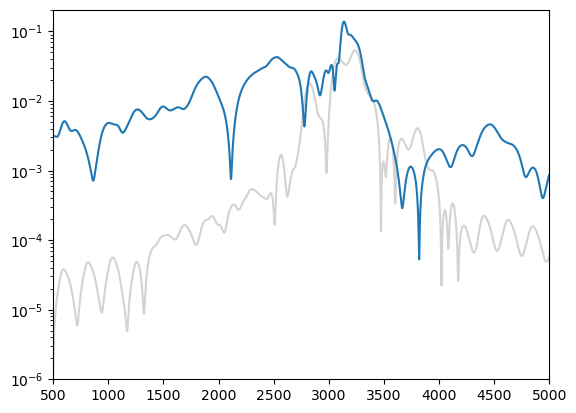

In [171]:
plt.semilogy(frequencies, jnp.abs(PM_strain)/jnp.sum(jnp.abs(PM_strain))*1e2)
plt.xlim(500,5000)
plt.ylim(1e-6,)
plt.semilogy(frequencies, jnp.abs(detector.filter_functions[jnp.argmax(n_sig_exp)]).T, color='lightgrey',zorder=-100)
plt.show()

In [172]:
# Make plot for the n_exp_photons 

points = jnp.array([(float(f0), float(t0)) for f0 in detector.f0_values for t0 in detector.t0_values])

color_values = [[0,0] for i in range(int(detector.N_total_filters/2))]

for i in range(detector.N_total_filters):
    
    label = detector.filter_labels[i]
    
    point_idx = int(jnp.argwhere(jnp.sum(jnp.array(points) - jnp.array(label[0:2]),axis=1) == 0)[0][0])
    
    if label[2] > 0:
        color_values[point_idx][1] = (n_sig_exp[i]/jnp.max(n_sig_exp))
        
    else:
        color_values[point_idx][0] = (n_sig_exp[i]/jnp.max(n_sig_exp))
        
color_values = jnp.array(color_values)

Text(0, 0.5, 'Time offset [s]')

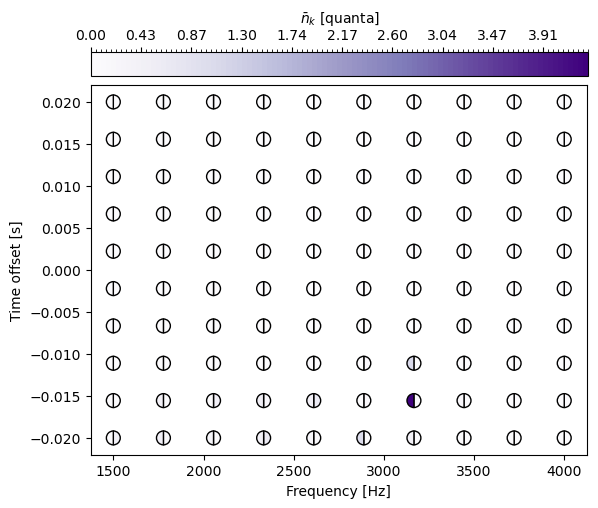

In [173]:
cmap = plt.cm.Purples
cmaplist = [cmap(i) for i in range(cmap.N)]

# create the new map
cmap = mpl.colors.LinearSegmentedColormap.from_list(
    'Custom cmap', cmaplist, cmap.N)

# define the bins and normalize
bounds = jnp.linspace(0, jnp.max(n_sig_exp), 100)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

fig = plt.figure()

ax = plt.gca()
plt.scatter(points.T[0], points.T[1], c=cmap(color_values.T[0]), edgecolor="k", marker=MarkerStyle("o", fillstyle="right"), s=100)
plt.scatter(points.T[0], points.T[1], c=cmap(color_values.T[1]), edgecolor="k", marker=MarkerStyle("o", fillstyle="left"), s=100)

ax2 = fig.add_axes([0.125, 0.9, 0.7775, 0.05])
cb = mpl.colorbar.ColorbarBase(ax2, cmap=cmap, label=r'$\bar{n}_{k}$ [quanta]', norm=norm,
                            boundaries=bounds, format='%.2f', orientation='horizontal')


ax2.xaxis.set_ticks_position('top')
ax2.xaxis.set_label_position('top')

ax.set_xlabel(r'Frequency [Hz]')
ax.set_ylabel(r'Time offset [s]')

In [174]:
import numpyro
from jax import random
import jax
import numpyro.infer.initialization as init
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS
import arviz as az

import numpy as np

numpyro.enable_x64()

In [175]:
geometric_dist = dist.Poisson(n_sig_exp)

In [176]:
n_obs_bank = geometric_dist.sample(random.PRNGKey(np.random.randint(0,100000)))

In [177]:
np.sum(n_obs_bank)

Array(11, dtype=int64)

In [179]:
print(jnp.max(n_obs_bank),jnp.argmax(n_obs_bank), detector.filter_labels[jnp.argmax(n_obs_bank)])

5 170 (3166.6666666666665, -0.015555555555555555, 1.5707963267948966)


In [180]:
def indiv_filter_likelihood(n, n_obs, n_bar_sig, n_bar_cl):
    
    return dist.Geometric(1/(n_bar_cl+1)).log_prob(n) + dist.Poisson(n_bar_sig).log_prob(n_obs-n)

def loglikelihood_function(n_obs, n_bar_sig, n_bar_cl):
    
    logl = 0
    
    n_max = 3#jnp.max(n_obs)
    n_idx_array = jnp.linspace(0,n_max, n_max+1, dtype=int)
    
    logl_vmap_n_indiv = jax.vmap(indiv_filter_likelihood, in_axes=(0,None, None, None))
    logl_vmap_ntot = jax.vmap(logl_vmap_n_indiv, in_axes=(None,0,0,0))
    
    logl_m_n = logl_vmap_ntot(n_idx_array, n_obs, n_bar_sig, n_bar_cl)
    
    logl_n = jax.scipy.special.logsumexp(logl_m_n, axis=1)
    
    logl = jnp.sum(logl_n)
        
    return logl

def loglikelihood_function_poisson(n_obs, n_bar_sig):
    
    logl = dist.Poisson(jnp.atleast_2d(n_bar_sig)).log_prob(n_obs)
    
    return jsp.special.logsumexp(jnp.sum(logl, axis=1), axis=0) - jnp.log(n_bar_sig.shape[0])

def loglikelihood_function_poisson_no_time_marg(n_obs, n_bar_sig):
    
    logl = dist.Poisson(n_bar_sig).log_prob(n_obs)
    
    return jnp.sum(logl, axis=1)

In [181]:
loglikelihood_function_poisson(n_obs_bank, n_sig_exp)

Array(-20.81691655, dtype=float64)

In [182]:
def model(n_true_bank):
    
    A = numpyro.sample('A', dist.Uniform(0,1e-19))
    f0 = numpyro.sample('f0', dist.Uniform(1.5e3, 4e3))
    gamma = numpyro.sample('gamma', dist.Uniform(10,2e3))
    phase = numpyro.sample('phase', dist.Uniform(0,jnp.pi)) # TODO maybe this only needs to be half of the range
    t0s = jnp.linspace(-0.02, 0.02, 100)
    
    n_pm_model = LorentzianModel.generate_photon_count(detector, frequencies, f0=f0, gamma=gamma, A=A, phase=phase, t0=t0s)
    
    #logl_pm_and_noise_bank = loglikelihood_function(n_true_bank, n_pm_model, detector.noise_photon_expectation)
    #logl_noise_bank = loglikelihood_function(n_true_bank, 1e-16*jnp.ones(detector.N_total_filters), detector.noise_photon_expectation)
    
    logl_pm = loglikelihood_function_poisson(n_true_bank, n_pm_model)
    
    #numpyro.factor('log_likelihood', logl_pm_and_noise_bank - logl_noise_bank)
    numpyro.factor('log_likelihood', logl_pm)

In [183]:
n_warmup = 1000
n_sample = 1000
n_chains = 2

kernel = NUTS(model, target_accept_prob=0.8)
mcmc = MCMC(kernel, num_warmup=n_warmup, num_samples=n_sample, num_chains=n_chains)
mcmc.run(jax.random.PRNGKey(np.random.randint(1<<32)), n_obs_bank)

fit_lorentzian_n = az.from_numpyro(mcmc)

/local/ethan.payne/ipykernel_494316/1917747953.py:6: UserWarning: There are not enough devices to run parallel chains: expected 2 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(2)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(kernel, num_warmup=n_warmup, num_samples=n_sample, num_chains=n_chains)
sample: 100%|██████████| 2000/2000 [03:35<00:00,  9.29it/s, 7 steps of size 3.04e-01. acc. prob=0.77] 


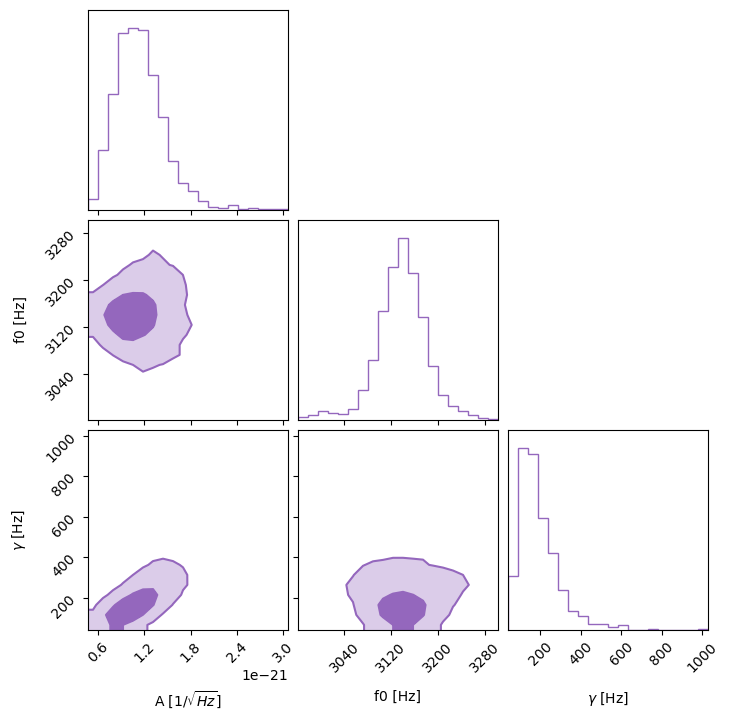

In [192]:
from corner import corner

fig = corner(fit_lorentzian_n.posterior, plot_datapoints=False, fill_contours=True, plot_density=False, color='C4', levels=[0.5,0.9], smooth=0.7, 
      var_names=['A', 'f0', 'gamma'], labels=[r'A [1/$\sqrt{Hz}$]', 'f0 [Hz]', r'$\gamma$ [Hz]'], hist_kwargs={'density':True}, truths=[None, None, None], truth_color='k')

array([[<AxesSubplot: title={'center': 'A'}>,
        <AxesSubplot: title={'center': 'A'}>],
       [<AxesSubplot: title={'center': 'f0'}>,
        <AxesSubplot: title={'center': 'f0'}>],
       [<AxesSubplot: title={'center': 'gamma'}>,
        <AxesSubplot: title={'center': 'gamma'}>],
       [<AxesSubplot: title={'center': 'phase'}>,
        <AxesSubplot: title={'center': 'phase'}>]], dtype=object)

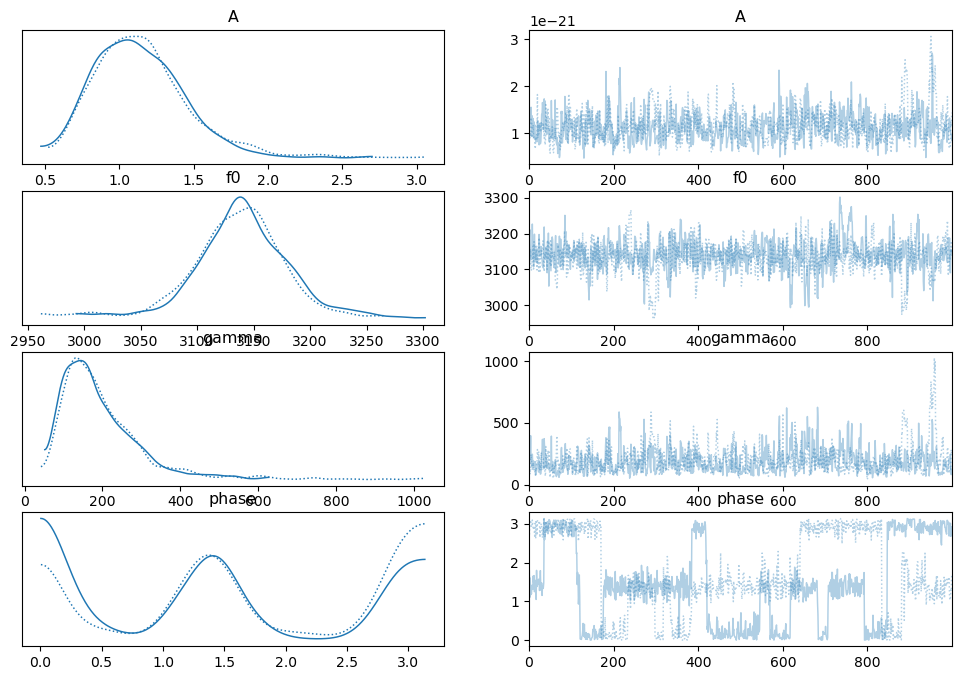

In [185]:
az.plot_trace(fit_lorentzian_n)